In [2]:
import os 
import cv2
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToPILImage
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
import shutil

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data

In [6]:
result_path= './data/frames/results.csv'
data = pd.read_csv(result_path)

results_cnts = data['Result'].value_counts()

print("number of 0:", results_cnts.get(0, 0))
print("number of 1:", results_cnts.get(1, 0))

number of 0: 62
number of 1: 44


In [ ]:
# We manually collected 106 match videos by recording the screen of the game.
# Now, we extract 70 images per video, and save them in the corresponding folder.
# After extracting the images, we manually selected the images that are not suitable for training, and removed them.

In [2]:
def extract_frames_per_match(csv_path, video_dir, output_dir, num_frames=70):
    data = pd.read_csv(csv_path)
    match_ids = data['Match'].unique()

    for match_id in tqdm(match_ids, desc="Processing Matches"):
        # Get video path for the match
        video_path = os.path.join(video_dir, f"{match_id}.mp4")
        if not os.path.exists(video_path):
            print(f"Warning: Video {match_id} does not exist.")
            continue

        # Create output folder
        match_output_dir = os.path.join(output_dir, f"{match_id}")
        os.makedirs(match_output_dir, exist_ok=True)

        # Read video
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Unable to open video {match_id}.")
            continue

        try:
            # Get video length and frame interval
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_interval = max(1, total_frames // num_frames)

            frame_count = 0
            extracted_count = 0

            with tqdm(total=num_frames, desc=f"Extracting frames for Match {match_id}", leave=False) as pbar:
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break

                    # Save frames at regular intervals
                    if frame_count % frame_interval == 0 and extracted_count < num_frames:
                        frame_path = os.path.join(match_output_dir, f"frame_{extracted_count:04d}.jpg")
                        cv2.imwrite(frame_path, frame)
                        extracted_count += 1
                        pbar.update(1)

                    frame_count += 1

        finally:
            cap.release()

        print(f"Extracted {extracted_count} frames for Match {match_id} in {match_output_dir}")

In [3]:
csv_path = './data/results.csv'
video_dir = './data/videos/'
output_dir = './data/frames/'

In [8]:
extract_frames_per_match(csv_path, video_dir, output_dir)

Processing Matches:   1%|          | 1/106 [02:41<4:42:38, 161.51s/it]

Extracted 70 frames for Match 1 in ./data/frames/1


Processing Matches:   2%|▏         | 2/106 [05:00<4:16:30, 147.99s/it]

Extracted 70 frames for Match 2 in ./data/frames/2


Processing Matches:   3%|▎         | 3/106 [07:22<4:09:35, 145.40s/it]

Extracted 70 frames for Match 3 in ./data/frames/3


Processing Matches:   4%|▍         | 4/106 [09:29<3:55:02, 138.26s/it]

Extracted 70 frames for Match 4 in ./data/frames/4


Processing Matches:   5%|▍         | 5/106 [11:56<3:57:42, 141.21s/it]

Extracted 70 frames for Match 5 in ./data/frames/5


Processing Matches:   6%|▌         | 6/106 [14:01<3:46:38, 135.98s/it]

Extracted 70 frames for Match 6 in ./data/frames/6


Processing Matches:   7%|▋         | 7/106 [16:05<3:37:36, 131.88s/it]

Extracted 70 frames for Match 7 in ./data/frames/7


Processing Matches:   8%|▊         | 8/106 [19:36<4:16:47, 157.21s/it]

Extracted 70 frames for Match 8 in ./data/frames/8


Processing Matches:   8%|▊         | 9/106 [22:52<4:33:23, 169.11s/it]

Extracted 70 frames for Match 9 in ./data/frames/9


Processing Matches:   9%|▉         | 10/106 [25:43<4:31:40, 169.80s/it]

Extracted 70 frames for Match 10 in ./data/frames/10


Processing Matches:  10%|█         | 11/106 [28:28<4:26:37, 168.39s/it]

Extracted 70 frames for Match 11 in ./data/frames/11


Processing Matches:  11%|█▏        | 12/106 [31:07<4:19:13, 165.47s/it]

Extracted 70 frames for Match 12 in ./data/frames/12


Processing Matches:  12%|█▏        | 13/106 [33:35<4:08:09, 160.11s/it]

Extracted 70 frames for Match 13 in ./data/frames/13


Processing Matches:  13%|█▎        | 14/106 [36:22<4:08:57, 162.37s/it]

Extracted 70 frames for Match 14 in ./data/frames/14


Processing Matches:  14%|█▍        | 15/106 [38:26<3:48:37, 150.74s/it]

Extracted 70 frames for Match 15 in ./data/frames/15


Processing Matches:  15%|█▌        | 16/106 [40:58<3:46:40, 151.11s/it]

Extracted 70 frames for Match 16 in ./data/frames/16


Processing Matches:  16%|█▌        | 17/106 [43:36<3:47:11, 153.17s/it]

Extracted 70 frames for Match 17 in ./data/frames/17


Processing Matches:  17%|█▋        | 18/106 [45:57<3:39:11, 149.45s/it]

Extracted 70 frames for Match 18 in ./data/frames/18


Processing Matches:  18%|█▊        | 19/106 [47:54<3:22:27, 139.63s/it]

Extracted 70 frames for Match 19 in ./data/frames/19


Processing Matches:  19%|█▉        | 20/106 [50:02<3:15:25, 136.35s/it]

Extracted 70 frames for Match 20 in ./data/frames/20


Processing Matches:  20%|█▉        | 21/106 [52:25<3:15:56, 138.31s/it]

Extracted 70 frames for Match 21 in ./data/frames/21


Processing Matches:  21%|██        | 22/106 [55:51<3:41:56, 158.53s/it]

Extracted 70 frames for Match 22 in ./data/frames/22


Processing Matches:  22%|██▏       | 23/106 [57:53<3:24:03, 147.51s/it]

Extracted 70 frames for Match 23 in ./data/frames/23


Processing Matches:  23%|██▎       | 24/106 [1:00:15<3:19:26, 145.94s/it]

Extracted 70 frames for Match 24 in ./data/frames/24


Processing Matches:  24%|██▎       | 25/106 [1:02:15<3:06:33, 138.20s/it]

Extracted 70 frames for Match 25 in ./data/frames/25


Processing Matches:  25%|██▍       | 26/106 [1:04:34<3:04:37, 138.47s/it]

Extracted 70 frames for Match 26 in ./data/frames/26


Processing Matches:  25%|██▌       | 27/106 [1:07:58<3:28:19, 158.22s/it]

Extracted 70 frames for Match 27 in ./data/frames/27


Processing Matches:  26%|██▋       | 28/106 [1:10:42<3:27:50, 159.88s/it]

Extracted 70 frames for Match 28 in ./data/frames/28


Processing Matches:  27%|██▋       | 29/106 [1:13:21<3:24:44, 159.54s/it]

Extracted 70 frames for Match 29 in ./data/frames/29


Processing Matches:  28%|██▊       | 30/106 [1:15:35<3:12:25, 151.91s/it]

Extracted 70 frames for Match 30 in ./data/frames/30


Processing Matches:  29%|██▉       | 31/106 [1:17:40<2:59:38, 143.71s/it]

Extracted 70 frames for Match 31 in ./data/frames/31


Processing Matches:  30%|███       | 32/106 [1:20:11<2:59:57, 145.91s/it]

Extracted 70 frames for Match 32 in ./data/frames/32


Processing Matches:  31%|███       | 33/106 [1:22:27<2:54:04, 143.08s/it]

Extracted 70 frames for Match 33 in ./data/frames/33


Processing Matches:  32%|███▏      | 34/106 [1:25:21<3:02:52, 152.39s/it]

Extracted 70 frames for Match 34 in ./data/frames/34


Processing Matches:  33%|███▎      | 35/106 [1:28:57<3:22:40, 171.27s/it]

Extracted 70 frames for Match 35 in ./data/frames/35


Processing Matches:  34%|███▍      | 36/106 [1:32:09<3:27:04, 177.50s/it]

Extracted 70 frames for Match 36 in ./data/frames/36


Processing Matches:  35%|███▍      | 37/106 [1:34:02<3:02:03, 158.31s/it]

Extracted 70 frames for Match 37 in ./data/frames/37


Processing Matches:  36%|███▌      | 38/106 [1:36:35<2:57:42, 156.80s/it]

Extracted 70 frames for Match 38 in ./data/frames/38


Processing Matches:  37%|███▋      | 39/106 [1:39:07<2:53:15, 155.16s/it]

Extracted 70 frames for Match 39 in ./data/frames/39


Processing Matches:  38%|███▊      | 40/106 [1:41:31<2:47:12, 152.00s/it]

Extracted 70 frames for Match 40 in ./data/frames/40


Processing Matches:  39%|███▊      | 41/106 [1:44:20<2:50:07, 157.04s/it]

Extracted 70 frames for Match 41 in ./data/frames/41


Processing Matches:  40%|███▉      | 42/106 [1:47:23<2:55:43, 164.75s/it]

Extracted 70 frames for Match 42 in ./data/frames/42


Processing Matches:  41%|████      | 43/106 [1:49:43<2:45:09, 157.29s/it]

Extracted 70 frames for Match 43 in ./data/frames/43


Processing Matches:  42%|████▏     | 44/106 [1:52:36<2:47:19, 161.93s/it]

Extracted 70 frames for Match 44 in ./data/frames/44


Processing Matches:  42%|████▏     | 45/106 [1:55:15<2:43:45, 161.07s/it]

Extracted 70 frames for Match 45 in ./data/frames/45


Processing Matches:  43%|████▎     | 46/106 [1:57:04<2:25:37, 145.63s/it]

Extracted 70 frames for Match 46 in ./data/frames/46


Processing Matches:  44%|████▍     | 47/106 [1:59:42<2:26:43, 149.22s/it]

Extracted 70 frames for Match 47 in ./data/frames/47


Processing Matches:  45%|████▌     | 48/106 [2:03:04<2:39:40, 165.18s/it]

Extracted 70 frames for Match 48 in ./data/frames/48


Processing Matches:  46%|████▌     | 49/106 [2:05:49<2:36:46, 165.02s/it]

Extracted 70 frames for Match 49 in ./data/frames/49


Processing Matches:  47%|████▋     | 50/106 [2:07:25<2:14:37, 144.25s/it]

Extracted 70 frames for Match 50 in ./data/frames/50


[NULL @ 0x111382ac0] Invalid NAL unit size (65009 > 50693).
[NULL @ 0x111382ac0] missing picture in access unit with size 50709
[h264 @ 0x31d56aee0] Invalid NAL unit size (65009 > 50693).
[h264 @ 0x31d56aee0] Error splitting the input into NAL units.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x11137f9e0] stream 1, offset 0x6d9cf7ec: partial file

Processing Matches:  48%|████▊     | 51/106 [2:10:38<2:25:44, 158.99s/it]ial file

Extracted 70 frames for Match 51 in ./data/frames/51


Processing Matches:  49%|████▉     | 52/106 [2:12:41<2:13:15, 148.06s/it]

Extracted 70 frames for Match 52 in ./data/frames/52


Processing Matches:  50%|█████     | 53/106 [2:15:28<2:15:58, 153.94s/it]

Extracted 70 frames for Match 53 in ./data/frames/53


Processing Matches:  51%|█████     | 54/106 [2:17:44<2:08:36, 148.39s/it]

Extracted 70 frames for Match 54 in ./data/frames/54


Processing Matches:  52%|█████▏    | 55/106 [2:20:48<2:15:17, 159.17s/it]

Extracted 70 frames for Match 55 in ./data/frames/55


Processing Matches:  53%|█████▎    | 56/106 [2:23:37<2:15:05, 162.11s/it]

Extracted 70 frames for Match 56 in ./data/frames/56


Processing Matches:  54%|█████▍    | 57/106 [2:26:12<2:10:45, 160.12s/it]

Extracted 70 frames for Match 57 in ./data/frames/57


Processing Matches:  55%|█████▍    | 58/106 [2:29:08<2:11:44, 164.67s/it]

Extracted 70 frames for Match 58 in ./data/frames/58


Processing Matches:  56%|█████▌    | 59/106 [2:31:31<2:03:56, 158.22s/it]

Extracted 70 frames for Match 59 in ./data/frames/59


Processing Matches:  57%|█████▋    | 60/106 [2:33:41<1:54:51, 149.82s/it]

Extracted 70 frames for Match 60 in ./data/frames/60


Processing Matches:  58%|█████▊    | 61/106 [2:36:54<2:02:07, 162.84s/it]

Extracted 70 frames for Match 61 in ./data/frames/61


Processing Matches:  58%|█████▊    | 62/106 [2:39:39<1:59:42, 163.24s/it]

Extracted 70 frames for Match 62 in ./data/frames/62


Processing Matches:  59%|█████▉    | 63/106 [2:41:52<1:50:38, 154.38s/it]

Extracted 70 frames for Match 63 in ./data/frames/63


Processing Matches:  60%|██████    | 64/106 [2:44:37<1:50:12, 157.45s/it]

Extracted 70 frames for Match 64 in ./data/frames/64


Processing Matches:  61%|██████▏   | 65/106 [2:46:52<1:42:58, 150.68s/it]

Extracted 70 frames for Match 65 in ./data/frames/65


Processing Matches:  62%|██████▏   | 66/106 [2:48:53<1:34:37, 141.93s/it]

Extracted 70 frames for Match 66 in ./data/frames/66


Processing Matches:  63%|██████▎   | 67/106 [2:51:37<1:36:24, 148.32s/it]

Extracted 70 frames for Match 67 in ./data/frames/67


Processing Matches:  64%|██████▍   | 68/106 [2:53:32<1:27:40, 138.44s/it]

Extracted 70 frames for Match 68 in ./data/frames/68


Processing Matches:  65%|██████▌   | 69/106 [2:55:49<1:25:05, 137.98s/it]

Extracted 70 frames for Match 69 in ./data/frames/69


Processing Matches:  66%|██████▌   | 70/106 [2:59:10<1:34:11, 156.98s/it]

Extracted 70 frames for Match 70 in ./data/frames/70


Processing Matches:  67%|██████▋   | 71/106 [3:01:31<1:28:42, 152.08s/it]

Extracted 70 frames for Match 71 in ./data/frames/71


Processing Matches:  68%|██████▊   | 72/106 [3:04:14<1:28:09, 155.56s/it]

Extracted 70 frames for Match 72 in ./data/frames/72


Processing Matches:  69%|██████▉   | 73/106 [3:06:56<1:26:36, 157.48s/it]

Extracted 70 frames for Match 73 in ./data/frames/73


Processing Matches:  70%|██████▉   | 74/106 [3:09:15<1:20:55, 151.73s/it]

Extracted 70 frames for Match 74 in ./data/frames/74


Processing Matches:  71%|███████   | 75/106 [3:13:10<1:31:24, 176.93s/it]

Extracted 70 frames for Match 75 in ./data/frames/75


Processing Matches:  72%|███████▏  | 76/106 [3:16:13<1:29:14, 178.47s/it]

Extracted 70 frames for Match 76 in ./data/frames/76


Processing Matches:  73%|███████▎  | 77/106 [3:18:45<1:22:32, 170.78s/it]

Extracted 70 frames for Match 77 in ./data/frames/77


Processing Matches:  74%|███████▎  | 78/106 [3:20:59<1:14:33, 159.76s/it]

Extracted 70 frames for Match 78 in ./data/frames/78


Processing Matches:  75%|███████▍  | 79/106 [3:23:46<1:12:49, 161.83s/it]

Extracted 70 frames for Match 79 in ./data/frames/79


Processing Matches:  75%|███████▌  | 80/106 [3:27:06<1:15:03, 173.20s/it]

Extracted 70 frames for Match 80 in ./data/frames/80


Processing Matches:  76%|███████▋  | 81/106 [3:30:00<1:12:19, 173.59s/it]

Extracted 70 frames for Match 81 in ./data/frames/81


Processing Matches:  77%|███████▋  | 82/106 [3:32:21<1:05:27, 163.66s/it]

Extracted 70 frames for Match 82 in ./data/frames/82


Processing Matches:  78%|███████▊  | 83/106 [3:35:00<1:02:14, 162.36s/it]

Extracted 70 frames for Match 83 in ./data/frames/83


Processing Matches:  79%|███████▉  | 84/106 [3:37:27<57:46, 157.59s/it]  

Extracted 70 frames for Match 84 in ./data/frames/84


Processing Matches:  80%|████████  | 85/106 [3:40:25<57:22, 163.95s/it]

Extracted 70 frames for Match 85 in ./data/frames/85


Processing Matches:  81%|████████  | 86/106 [3:43:28<56:31, 169.57s/it]

Extracted 70 frames for Match 86 in ./data/frames/86


Processing Matches:  82%|████████▏ | 87/106 [3:46:02<52:12, 164.89s/it]

Extracted 70 frames for Match 87 in ./data/frames/87


Processing Matches:  83%|████████▎ | 88/106 [3:48:38<48:37, 162.08s/it]

Extracted 70 frames for Match 88 in ./data/frames/88


Processing Matches:  84%|████████▍ | 89/106 [3:51:30<46:46, 165.07s/it]

Extracted 70 frames for Match 89 in ./data/frames/89


Processing Matches:  85%|████████▍ | 90/106 [3:53:55<42:27, 159.20s/it]

Extracted 70 frames for Match 90 in ./data/frames/90


Processing Matches:  86%|████████▌ | 91/106 [3:55:56<36:56, 147.79s/it]

Extracted 70 frames for Match 91 in ./data/frames/91


Processing Matches:  87%|████████▋ | 92/106 [3:59:13<37:52, 162.35s/it]

Extracted 70 frames for Match 92 in ./data/frames/92


Processing Matches:  88%|████████▊ | 93/106 [4:01:26<33:16, 153.58s/it]

Extracted 70 frames for Match 93 in ./data/frames/93


Processing Matches:  89%|████████▊ | 94/106 [4:03:43<29:44, 148.69s/it]

Extracted 70 frames for Match 94 in ./data/frames/94


Processing Matches:  90%|████████▉ | 95/106 [4:06:44<29:01, 158.35s/it]

Extracted 70 frames for Match 95 in ./data/frames/95


Processing Matches:  91%|█████████ | 96/106 [4:09:09<25:43, 154.34s/it]

Extracted 70 frames for Match 96 in ./data/frames/96


Processing Matches:  92%|█████████▏| 97/106 [4:11:14<21:50, 145.65s/it]

Extracted 70 frames for Match 97 in ./data/frames/97


Processing Matches:  92%|█████████▏| 98/106 [4:13:31<19:04, 143.11s/it]

Extracted 70 frames for Match 98 in ./data/frames/98


Processing Matches:  93%|█████████▎| 99/106 [4:15:37<16:04, 137.79s/it]

Extracted 70 frames for Match 99 in ./data/frames/99


Processing Matches:  94%|█████████▍| 100/106 [4:18:03<14:02, 140.34s/it]

Extracted 70 frames for Match 100 in ./data/frames/100


Processing Matches:  95%|█████████▌| 101/106 [4:20:35<11:58, 143.70s/it]

Extracted 70 frames for Match 101 in ./data/frames/101


Processing Matches:  96%|█████████▌| 102/106 [4:22:39<09:11, 137.86s/it]

Extracted 70 frames for Match 102 in ./data/frames/102


Processing Matches:  97%|█████████▋| 103/106 [4:24:44<06:42, 134.08s/it]

Extracted 70 frames for Match 103 in ./data/frames/103


Processing Matches:  98%|█████████▊| 104/106 [4:26:52<04:24, 132.12s/it]

Extracted 70 frames for Match 104 in ./data/frames/104


Processing Matches:  99%|█████████▉| 105/106 [4:29:18<02:16, 136.42s/it]

Extracted 70 frames for Match 105 in ./data/frames/105


Processing Matches: 100%|██████████| 106/106 [4:31:47<00:00, 153.84s/it]

Extracted 70 frames for Match 106 in ./data/frames/106


In [7]:
# Integrate all matches, then split
def split_dataset(frames_dir, csv_path, output_dir, test_size=0.2, val_size=0.2):
    results = pd.read_csv(csv_path)

    all_data = []

    for match_id in sorted(os.listdir(frames_dir)):
        match_folder = os.path.join(frames_dir, match_id)
        # if match folder does not exist, skip
        if not os.path.isdir(match_folder):
            print(f"Match folder {match_folder} does not exist.")
            continue
        
        # Get results for the match_id
        match_result = results.loc[results['Match'] == int(match_id), 'Result']
        if match_result.empty:
            print(f"No result found for match {match_id}.")
            continue
        
        label = match_result.values[0]

        for img_file in os.listdir(match_folder):
            img_path = os.path.join(match_folder, img_file)
            if img_file.endswith('.jpg'):
                unique_name = f"Match_{match_id}_{img_file}" 
                all_data.append({'image': img_path, 'label': label, 'match_id': match_id, 'unique_name': unique_name})
    
    df = pd.DataFrame(all_data)

    # Split the dataset
    train_df, temp_df = train_test_split(df, test_size=test_size + val_size, random_state=42, stratify=df['label'])
    val_df, test_df = train_test_split(temp_df, test_size=test_size / (test_size + val_size), random_state=42, stratify=temp_df['label'])

    # Save the split datasets
    def save_dataset(split_df, split_name):
        split_dir = os.path.join(output_dir, split_name)
        os.makedirs(split_dir, exist_ok=True)

        labels = []
        for _, row in split_df.iterrows():
            dest_path = os.path.join(split_dir, row['unique_name'])
            shutil.copy(row['image'], dest_path)
            labels.append({'image': row['unique_name'], 'label': row['label'], 'match_id': row['match_id']})
        
        labels_df = pd.DataFrame(labels)
        labels_df.to_csv(os.path.join(output_dir, f"{split_name}_labels.csv"), index=False)
    
    save_dataset(train_df, "train")
    save_dataset(val_df, "val")
    save_dataset(test_df, "test")

    print("Dataset split completed.")    

In [ ]:
frames_dir = "./data/frames/"               
csv_path = "./data/frames/results.csv"             
output_dir = "./data/split_dataset/"        
split_dataset(frames_dir, csv_path, output_dir)

Dataset split completed.


In [3]:
def count_images_in_folders(base_dir):
    splits = ["train", "val", "test"] 
    counts = {}

    for split in splits:
        split_dir = os.path.join(base_dir, split)
        if not os.path.exists(split_dir):
            print(f"{split_dir} does not exist.")
            continue
        
        image_files = [f for f in os.listdir(split_dir) if f.lower().endswith(('.jpg'))]
        counts[split] = len(image_files)

    return counts

base_dir = "./data/split_dataset/" 
counts = count_images_in_folders(base_dir)

for split, count in counts.items():
    print(f"{split.capitalize()} folder has {count} images.")

Train folder has 3444 images.
Val folder has 1148 images.
Test folder has 1149 images.


In [11]:
# split the dataset by match
def split_dataset_by_match(frames_dir, csv_path, output_dir, test_size=0.2, val_size=0.2):
    results = pd.read_csv(csv_path)

    match_ids = results['Match'].unique()

    # split the match ids
    train_ids, temp_ids = train_test_split(match_ids, test_size=test_size + val_size, random_state=42, stratify=results['Result'])
    val_ids, test_ids = train_test_split(temp_ids, test_size=test_size / (test_size + val_size), random_state=42, stratify=results[results['Match'].isin(temp_ids)]['Result'])

    # print the number of matches in each split
    print(f"Train Matches: {len(train_ids)}, Val Matches: {len(val_ids)}, Test Matches: {len(test_ids)}")

    # copy the images for each split
    def copy_matches(match_ids, split_name):
        split_dir = os.path.join(output_dir, split_name)
        os.makedirs(split_dir, exist_ok=True)
        labels = []

        for match_id in match_ids:
            match_folder = os.path.join(frames_dir, str(match_id))
            if not os.path.exists(match_folder):
                print(f"Warning: Match folder {match_folder} not found. Skipping.")
                continue

            # copy images for the match
            for img_file in os.listdir(match_folder):
                if img_file.endswith(('.jpg', '.png', '.jpeg')):
                    src = os.path.join(match_folder, img_file)
                    dest_filename = f"Match_{match_id}_{img_file}"
                    dest = os.path.join(split_dir, dest_filename)
                    shutil.copy(src, dest)
                    labels.append({'image': dest_filename, 'label': results.loc[results['Match'] == match_id, 'Result'].values[0], 'match_id': match_id})

        labels_df = pd.DataFrame(labels)
        labels_df.to_csv(os.path.join(output_dir, f"{split_name}_labels.csv"), index=False)

    copy_matches(train_ids, "train")
    copy_matches(val_ids, "val")
    copy_matches(test_ids, "test")

    print("Dataset split by match completed.")

In [ ]:
frames_dir = "./data/frames/"                
csv_path = "./data/frames/results.csv"
output_dir = "./data/split_by_match_dataset/"

split_dataset_by_match(frames_dir, csv_path, output_dir)

Train Matches: 63, Val Matches: 21, Test Matches: 22
Dataset split by match completed.


In [4]:
base_dir = "./data/augmented_split_by_match_dataset/"
counts = count_images_in_folders(base_dir)

for split, count in counts.items():
    print(f"{split.capitalize()} folder has {count} images.")

Train folder has 13548 images.
Val folder has 4628 images.
Test folder has 4788 images.


In [ ]:
# Now, we need to get areas we gonna use. Outside of the selected areas will be blacked out.

In [4]:
drawing = False  
ix, iy = -1, -1  
rect_coords = [] 

def draw_rectangle(event, x, y, flags, param):
    global ix, iy, drawing, rect_coords

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x, y

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            temp_image = param.copy()  
            cv2.rectangle(temp_image, (ix, iy), (x, y), (0, 255, 0), 2)
            cv2.imshow("Image", temp_image)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False

        cv2.rectangle(param, (ix, iy), (x, y), (0, 255, 0), 2)
        cv2.imshow("Image", param)

        rect_coords.append((ix, iy, x, y))


image = cv2.imread("./data/split_dataset/train/Match_9_frame_0052.jpg") 
cv2.imshow("Image", image)

cv2.setMouseCallback("Image", draw_rectangle, param=image)

print("Draw rectangles on the image. Press 'q' to quit.")
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'): 
        break

cv2.destroyAllWindows()

print("Saved rectangle coordinates:")
for coords in rect_coords:
    print(f"Top-left: ({coords[0]}, {coords[1]}), Bottom-right: ({coords[2]}, {coords[3]})")

: 

Please ignore the above red messages. After extracting coordinates and quit windows, the python kernel dead, but the corrdinates are successfully extracted.

In [5]:
rect_coords = [
    (675, 10, 1242, 85),
    (1755, 5, 1916, 72),
    (292, 95, 2, 5),
    (1630, 793, 1915, 1074),
    (597, 846, 1335, 1077),
    (1828, 126, 1918, 648),
    (83, 132, 1, 655),
]

In [6]:
class MaskTransform:
    def __init__(self, rect_coords):
        self.rect_coords = rect_coords

    def __call__(self, image):
        # all black mask
        mask = Image.new('RGB', image.size, (0, 0, 0))
        draw = ImageDraw.Draw(mask)

        for rect in self.rect_coords:
            x1, y1 = min(rect[0], rect[2]), min(rect[1], rect[3])
            x2, y2 = max(rect[0], rect[2]), max(rect[1], rect[3])
            # whiltens the selected areas
            draw.rectangle([x1, y1, x2, y2], fill=(255, 255, 255))

        # composite the image and mask
        masked_image = Image.composite(image, mask, mask.convert("L")) 
        return masked_image

class MatchDataset(Dataset):
    def __init__(self, labels_csv, images_dir, transform=None):
        self.data = pd.read_csv(labels_csv)
        self.images_dir = images_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.images_dir, row['image'])
        label = row['label']

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [7]:
transform = transforms.Compose([
    MaskTransform(rect_coords),      
    transforms.Resize((600, 600)),   
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [8]:
def create_dataloader(split_name, base_dir, transform, batch_size=32, shuffle=True):
    labels_csv = os.path.join(base_dir, f"{split_name}_labels.csv")
    images_dir = os.path.join(base_dir, split_name)
    dataset = MatchDataset(labels_csv, images_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [19]:
base_dir = './data/split_dataset'
base_dir_by_match = './data/split_by_match_dataset'
batch_size = 32

In [10]:
train_loader = create_dataloader("train", base_dir, transform, batch_size=batch_size)
val_loader = create_dataloader("val", base_dir, transform, batch_size=batch_size)
test_loader = create_dataloader("test", base_dir, transform, batch_size=batch_size)

train_loader_by_match = create_dataloader("train", base_dir_by_match, transform, batch_size=batch_size)
val_loader_by_match = create_dataloader("val", base_dir_by_match, transform, batch_size=batch_size)
test_loader_by_match = create_dataloader("test", base_dir_by_match, transform, batch_size=batch_size)

In [12]:
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  
    return tensor

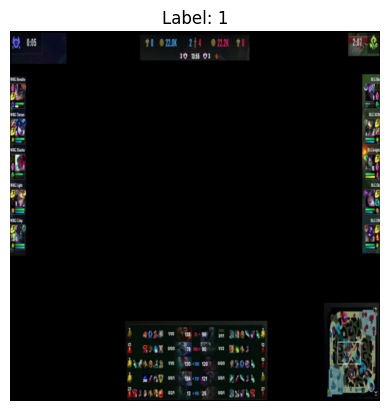

In [13]:
# observe that the data is correctly masked and loaded to the dataloader.
image, label = train_loader.dataset[0]
unnorm_image = unnormalize(image.clone(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

to_pil = ToPILImage()
pil_image = to_pil(unnorm_image)


plt.imshow(pil_image)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

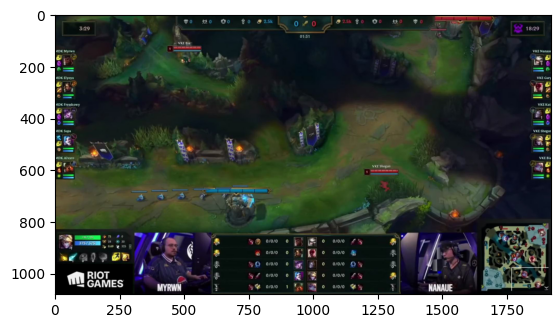

In [25]:
image = Image.open("./data/augmented_split_dataset/train/Match_1_frame_0000.jpg")
plt.imshow(image)
plt.show()

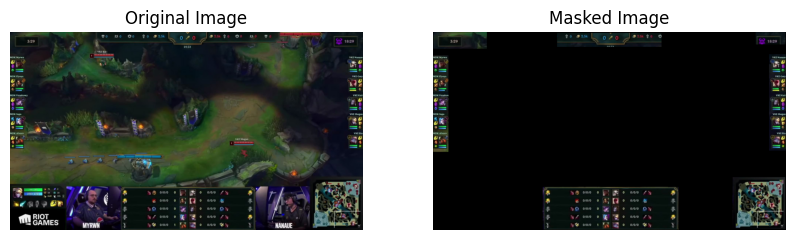

In [26]:
image = Image.open("./data/augmented_split_dataset/train/Match_1_frame_0000.jpg").convert("RGB")  # read image
masked_image = MaskTransform(rect_coords)(image)  # apply masking

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(masked_image)
plt.title("Masked Image")
plt.axis("off")

plt.show()

In [ ]:
# Based on the Efficient Paper, we first need to define MVConvBlock since the main building block of the EfficientNet is mobile inverted bottleneck MBConv. It hs three steps:

# 1. Expansion Phase: it expands the number of channels with expansion ratio.
# 2. Depthwise Convolution: it applies depthwise convolution to reduce the number of parameters (By computing independent channel-wise convolution, we can learn temporal information
# while maintaining the channel structure).
# 3. proection Phase: it projects the number of channels to the desired number of channels.

# Additionally, there are two generally used techniques, which are Squeeze-andExcitation (SE) module and skip connection
# 1. SE module: It applies weights to the channels to emphasize the important channels.
# 2. Skip connection: It is used to avoid the vanishing gradient problem (Condition: input and output channels are the same).

# Baswed on the above definition, we can define the MVConvBlock as follows:

In [14]:
class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_ratio, stride, kernel_size, se_ratio=0.25):
        super(MBConvBlock, self).__init__()
        self.stride = stride
        mid_channels = in_channels * expansion_ratio

        # 1. Expansion Phase. no need to add bias since we have batch normalization
        self.expansion = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels, momentum=0.99)
        self.act1 = nn.SiLU()

        # 2. Depthwise Convolution
        self.depthwise = nn.Conv2d(mid_channels, mid_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, groups=mid_channels, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels, momentum=0.99)
        self.act2 = nn.SiLU()

        # SE module -> learn channel-wise interactions suc that the network can dynamically learn which channels are important
        se_channels = max(1, int(in_channels * se_ratio))
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Global Average Pooling: HxWxC -> 1x1 ==> it compresses the spatial information to a single value, showing global information
            nn.Conv2d(mid_channels, se_channels, kernel_size=1), # reduce the number of channels
            nn.SiLU(), # apply non-linearity
            nn.Conv2d(se_channels, mid_channels, kernel_size=1), # restore the number of channels
            nn.Sigmoid() # apply sigmoid to get the weights
        )

        # 3. Projection Phase
        self.projection = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels, momentum=0.99)

        # Skip connection -> can only apply when the input and output channels are the same
        self.apply_residual = (in_channels == out_channels) and (stride == 1)

    def forward(self, x):
        residual = x
        x = self.expansion(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.depthwise(x)
        x = self.bn2(x)
        x = self.act2(x)

        # apply SE module
        weights = self.se(x)
        x = x * weights

        x = self.projection(x)
        x = self.bn3(x)

        if self.apply_residual:
            x = x + residual
        
        return x

In [ ]:
# Now, we can define the EfficientNet model based on the above building block. The EfficientNet model consists of multiple MVConvBlocks with different parameters. The model has the following steps:
# The model structure is defined in Page 7 of the EfficientNet paper:

In [15]:
class EfficientNet(nn.Module):
    def __init__(self, num_classes=2):
        super(EfficientNet, self).__init__()
        base_channels = 32

        # Stage 1: Conv3x3
        self.stage_1 = nn.Sequential(
            nn.Conv2d(3, base_channels, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base_channels, momentum=0.99),
            nn.SiLU()
        )

        # Stages 2 ~ 8
        # in_channels, out_channels, num_blocks, stride, kernel_size, expansion_ratio
        stages = [
            [32, 16, 1, 1, 3, 1], # stage 2: 112x112 -> 112x112, 32 -> 16, num layers: 1, k3x3
            [16, 24, 2, 2, 3, 6], # stage 3: 112x112 -> 56x56, 16->24, num layers: 2, k3x3
            [24, 40, 2, 2, 5, 6], # stage 4: 56x56 -> 28x28, 24->40, num layers: 2, k5x5
            [40, 80, 3, 2, 3, 6], # stage 5: 28x28 -> 14x14, 40->80, num layers: 3, k3x3
            [80, 112, 3, 1, 5, 6], # stage 6: 14x14 -> 14x14, 80->112, num layers: 3, k5x5
            [112, 192, 4, 2, 5, 6], # stage 7: 14x14 -> 7x7, 112->192, num layers: 4, k5x5
            [192, 320, 1, 1, 3, 6] # stage 8: 7x7 -> 7x7, 192->320, num layers: 1, k3x3
        ]

        # MBCovBlocks
        layers = []
        in_channels_last = base_channels
        for in_channels, out_channels, num_blocks, stride, kernel_size, expansion_ratio in stages:
            for i in range(num_blocks):
                layers.append(MBConvBlock(
                    in_channels_last, 
                    out_channels, 
                    expansion_ratio, 
                    stride if i == 0 else 1, # only apply kernel to the first block 
                    kernel_size))
                in_channels_last = out_channels
        
        self.mbconv_stages = nn.Sequential(*layers)
        
        # Stage 9: Conv1x1
        self.stage_9 = nn.Sequential(
            nn.Conv2d(in_channels_last, 1280, kernel_size=1, bias=False), # 7 x 7 x 320 -> 7 x 7 x 1280
            nn.BatchNorm2d(1280, momentum=0.99),
            nn.SiLU(),
            nn.AdaptiveAvgPool2d(1) # 7 x 7 x 1280 -> 1 x 1 x 1280
        )

        # fc 
        self.classifier = nn.Sequential(
            nn.Dropout(0.2), # based on the paper, the droupout is 0.2 for EfficientNet-B0
            nn.Linear(1280, num_classes)
        )
    
    # forward
    def forward(self, x):
        x = self.stage_1(x)
        # print(f"x: {x.shape}")
        x = self.mbconv_stages(x)
        # print(f"x: {x.shape}")
        x = self.stage_9(x)
        # print(f"x: {x.shape}")
        # need to flatten the tensor
        x = x.flatten(start_dim=1)  # 1x1x1280 -> 1280

        x = self.classifier(x)
        return x

In [ ]:
# We apply early stopping to avoid overfitting. The early stopping is based on the validation loss.

In [16]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, path='./weights/best_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.path = path
    
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            print(f"Validation loss decreased ({self.best_loss:.4f} -> {val_loss:.4f}). Saving model...")
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
    
    def save_checkpoint(self, val_loss, model):        
        torch.save(model.state_dict(), self.path)

In [17]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, weight_name, num_epochs=100, patience=10):
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=f'weights/best_{weight_name}.pth')

    # save
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        # Train
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(30*"-")

        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        train_acc = correct_train / total_train * 100
        train_loss /= len(train_loader)

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)

        print(f"Training loss: {train_loss:.4f}, accuracy: {train_acc:.2f}%")
    

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
            
        val_acc = correct_val / total_val * 100
        val_loss /= len(val_loader)

        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        print(f"Validation loss: {val_loss:.4f}, accuracy: {val_acc:.2f}%")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        # update learning rate -> every 24 epoch
        if (epoch+1) % 24 == 0:
            scheduler.step()
            print(f"Learning rate updated")

    model.load_state_dict(torch.load(f'weights/best_{weight_name}.pth'))
    print("Training completed and the best model is loaded.")
    return model, history


In [18]:
# Test 
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)
    
    test_accuracy = 100 * correct_test / total_test
    test_loss = test_loss / len(test_loader)

    print(f"Test loss: {test_loss:.4f}, accuracy: {test_accuracy:.2f}%")
    return test_loss, test_accuracy

In [ ]:
def plot_history(history, save_path=None):

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # loss graph
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title('Loss Over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # accuracy graph
    axes[1].plot(history['train_acc'], label='Train Accuracy')
    axes[1].plot(history['val_acc'], label='Validation Accuracy')
    axes[1].set_title('Accuracy Over Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(f"{save_path}_combined.png")
    plt.show()

    # save individual plots
    # trian loss
    plt.figure(figsize=(7, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.title('Train Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(f"{save_path}_train_loss.png")
    plt.show()

    # validation loss
    plt.figure(figsize=(7, 5))
    plt.plot(history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(f"{save_path}_val_loss.png")
    plt.show()

    # train accuracy
    plt.figure(figsize=(7, 5))
    plt.plot(history['train_acc'], label='Train Accuracy', color='green')
    plt.title('Train Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(f"{save_path}_train_acc.png")
    plt.show()

    # validation accuracy
    plt.figure(figsize=(7, 5))
    plt.plot(history['val_acc'], label='Validation Accuracy', color='red')
    plt.title('Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(f"{save_path}_val_acc.png")
    plt.show()

In [21]:
random_shuffle_model = EfficientNet(num_classes=2)
random_shuffle_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(random_shuffle_model.parameters(), lr=0.001)

# decay the learning rate by a factor of 0.9 for every 24 epoch
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)  

In [22]:
random_shuffle_model, random_shuffle_history = train(
    model=random_shuffle_model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    device=device, 
    weight_name="random_shuffle_model", 
    num_epochs=100, 
    patience=3)

Epoch 1/100
------------------------------


Training: 100%|██████████| 431/431 [03:12<00:00,  2.24it/s]


Training loss: 0.4259, accuracy: 80.63%


Validation: 100%|██████████| 144/144 [00:49<00:00,  2.94it/s]


Validation loss: 0.3232, accuracy: 84.49%
Validation loss decreased (inf -> 0.3232). Saving model...
Epoch 2/100
------------------------------


Training: 100%|██████████| 431/431 [02:48<00:00,  2.56it/s]


Training loss: 0.2049, accuracy: 91.99%


Validation: 100%|██████████| 144/144 [00:48<00:00,  2.97it/s]


Validation loss: 0.2233, accuracy: 92.25%
Validation loss decreased (0.3232 -> 0.2233). Saving model...
Epoch 3/100
------------------------------


Training: 100%|██████████| 431/431 [02:48<00:00,  2.56it/s]


Training loss: 0.1252, accuracy: 95.93%


Validation: 100%|██████████| 144/144 [00:48<00:00,  2.98it/s]


Validation loss: 0.2246, accuracy: 93.64%
EarlyStopping counter: 1 out of 3
Epoch 4/100
------------------------------


Training: 100%|██████████| 431/431 [02:48<00:00,  2.55it/s]


Training loss: 0.0741, accuracy: 97.59%


Validation: 100%|██████████| 144/144 [00:48<00:00,  2.97it/s]


Validation loss: 0.3064, accuracy: 92.86%
EarlyStopping counter: 2 out of 3
Epoch 5/100
------------------------------


Training: 100%|██████████| 431/431 [02:48<00:00,  2.56it/s]


Training loss: 0.0869, accuracy: 97.01%


Validation: 100%|██████████| 144/144 [00:48<00:00,  2.95it/s]


Validation loss: 0.1671, accuracy: 93.47%
Validation loss decreased (0.2233 -> 0.1671). Saving model...
Epoch 6/100
------------------------------


Training: 100%|██████████| 431/431 [02:48<00:00,  2.56it/s]


Training loss: 0.0540, accuracy: 98.03%


Validation: 100%|██████████| 144/144 [00:48<00:00,  2.98it/s]


Validation loss: 0.1384, accuracy: 94.95%
Validation loss decreased (0.1671 -> 0.1384). Saving model...
Epoch 7/100
------------------------------


Training: 100%|██████████| 431/431 [02:48<00:00,  2.56it/s]


Training loss: 0.0560, accuracy: 97.74%


Validation: 100%|██████████| 144/144 [00:48<00:00,  2.96it/s]


Validation loss: 0.1164, accuracy: 95.64%
Validation loss decreased (0.1384 -> 0.1164). Saving model...
Epoch 8/100
------------------------------


Training: 100%|██████████| 431/431 [02:48<00:00,  2.55it/s]


Training loss: 0.0304, accuracy: 98.87%


Validation: 100%|██████████| 144/144 [00:48<00:00,  2.96it/s]


Validation loss: 0.0033, accuracy: 99.91%
Validation loss decreased (0.1164 -> 0.0033). Saving model...
Epoch 9/100
------------------------------


Training: 100%|██████████| 431/431 [02:48<00:00,  2.56it/s]


Training loss: 0.0017, accuracy: 99.97%


Validation: 100%|██████████| 144/144 [00:48<00:00,  2.95it/s]


Validation loss: 0.0166, accuracy: 99.39%
EarlyStopping counter: 1 out of 3
Epoch 10/100
------------------------------


Training: 100%|██████████| 431/431 [02:48<00:00,  2.56it/s]


Training loss: 0.1076, accuracy: 95.91%


Validation: 100%|██████████| 144/144 [00:48<00:00,  2.99it/s]


Validation loss: 0.0046, accuracy: 99.91%
EarlyStopping counter: 2 out of 3
Epoch 11/100
------------------------------


Training: 100%|██████████| 431/431 [02:48<00:00,  2.56it/s]


Training loss: 0.0603, accuracy: 98.37%


Validation: 100%|██████████| 144/144 [00:48<00:00,  2.96it/s]
/tmp/ipykernel_656632/1976212492.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(tor

Validation loss: 0.0323, accuracy: 98.78%
EarlyStopping counter: 3 out of 3
Early stopping
Training completed and the best model is loaded.


In [25]:
test_random_shuffle_loss, test_random_shuffle_acc = test(random_shuffle_model, test_loader, criterion, device)

Testing: 100%|██████████| 144/144 [00:48<00:00,  2.95it/s]

Test loss: 0.0092, accuracy: 99.83%


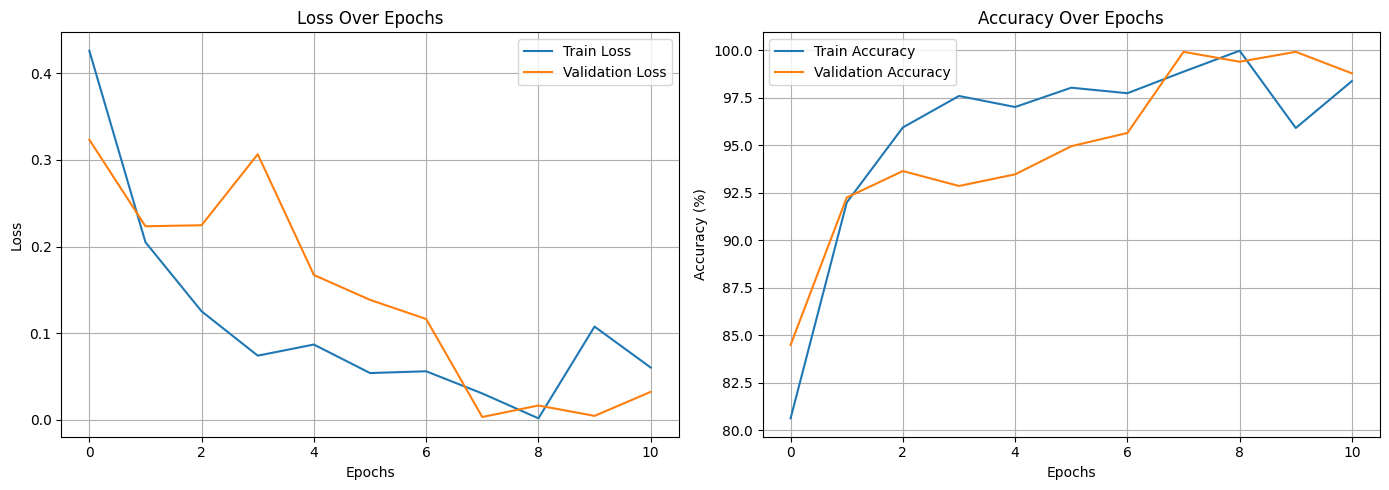

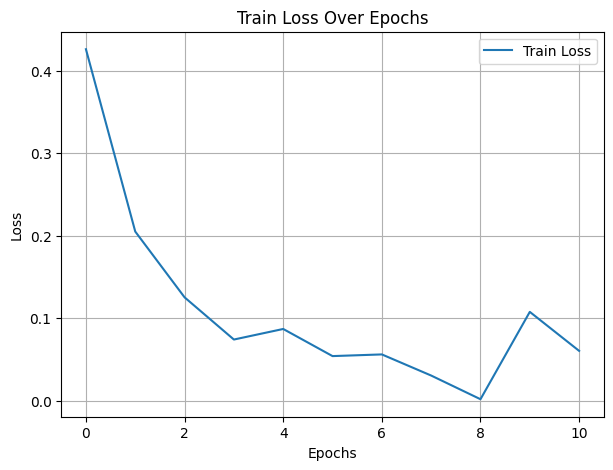

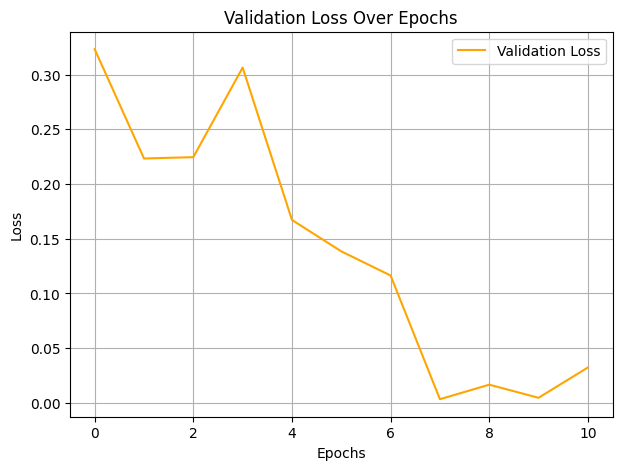

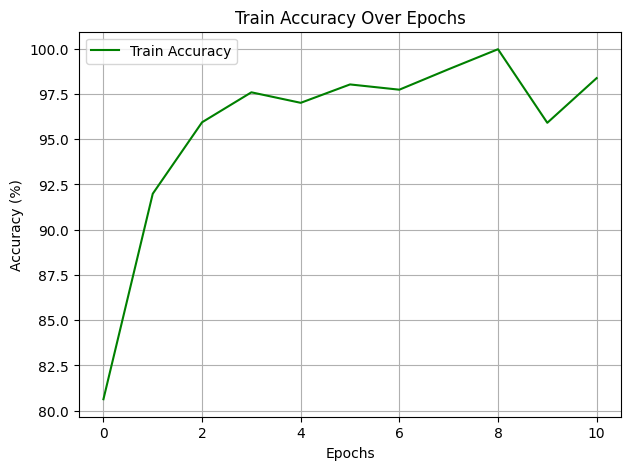

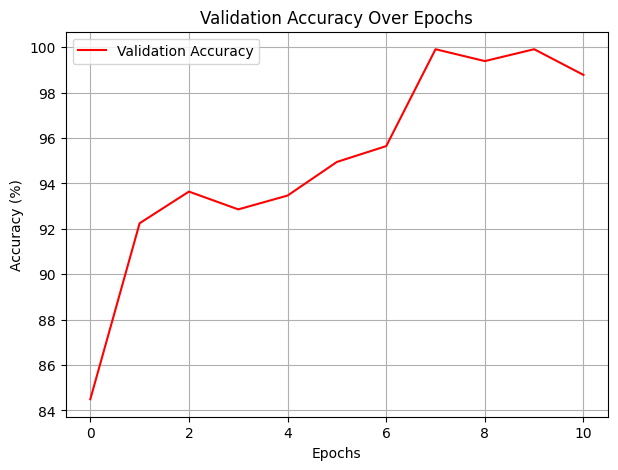

In [26]:
plot_history(random_shuffle_history, save_path="./graphs/random_shuffle_results")